In [10]:
import time
from Arm_Lib import Arm_Device
Arm  = Arm_Device()

In [11]:
from roboticstoolbox import *
from spatialmath import *
from math import pi
import numpy as np

%matplotlib widget

In [12]:

DFbot = DHRobot(
    [
        RevoluteDH(d=0.04145,alpha=np.pi/2,qlim=np.array([-np.pi,np.pi])),
        RevoluteDH(a=-0.08285,qlim=np.array([-np.pi,np.pi])),
        RevoluteDH(a=-0.08285,qlim=np.array([-np.pi,np.pi])),
        RevoluteDH(alpha=-np.pi/2,qlim=np.array([-np.pi,np.pi])),
        RevoluteDH(d=0.11,qlim=np.array([-np.pi,3/2*np.pi]))
    ],
    name = "DFbot",
)
'''
DFbot = DHRobot(
    [
        RevoluteMDH(d=0.04145,qlim=np.array([-np.pi,np.pi])),
        RevoluteMDH(alpha=np.pi/2,qlim=np.array([-np.pi,np.pi])),
        RevoluteMDH(a=-0.08285,qlim=np.array([-np.pi,np.pi])),
        RevoluteMDH(a=-0.08285,qlim=np.array([-np.pi,np.pi])),
        RevoluteMDH(alpha=-np.pi/2,d=0.075,qlim=np.array([-np.pi,np.pi])),
    ],
    name = "DFbot",
)
'''
print(DFbot)

DHRobot: DFbot, 5 joints (RRRRR), dynamics, standard DH parameters
┌─────┬─────────┬──────────┬────────┬─────────┬────────┐
│ θⱼ  │   dⱼ    │    aⱼ    │   ⍺ⱼ   │   q⁻    │   q⁺   │
├─────┼─────────┼──────────┼────────┼─────────┼────────┤
│  q1 │ 0.04145 │        0 │  90.0° │ -180.0° │ 180.0° │
│  q2 │       0 │ -0.08285 │   0.0° │ -180.0° │ 180.0° │
│  q3 │       0 │ -0.08285 │   0.0° │ -180.0° │ 180.0° │
│  q4 │       0 │        0 │ -90.0° │ -180.0° │ 180.0° │
│  q5 │    0.11 │        0 │   0.0° │ -180.0° │ 270.0° │
└─────┴─────────┴──────────┴────────┴─────────┴────────┘

┌──┬──┐
└──┴──┘



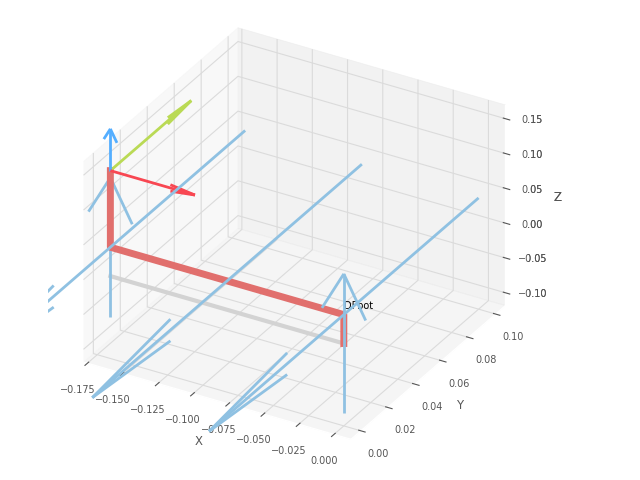

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'DFbot')

In [13]:
DFbot.plot([0,0,0,0,0]) #这是仿真结果，我们希望真实结果（全零的起始位）和仿真结果相同

In [6]:
#偏置Offset和方向调换：
import numpy as np
def FK_control(joint_angles):#joint_angle为一个（6，）的numpy array

    # 确保输入是numpy数组
    joint_angles = np.asarray(joint_angles)
    
    # 检查输入形状是否正确
    if joint_angles.shape != (6,):
        raise ValueError("The shape of input angles must be 6!")
    
    # 计算新的关节角
    j1 = +joint_angles[0] + 90
    j2 = -joint_angles[1]
    j3 = -joint_angles[2] + 90
    j4 = -joint_angles[3] + 180
    j5 = +joint_angles[4] + 90
    j6 = -joint_angles[5] + 180 #input的角越小，夹爪越收紧！

    #关节限位检测
    if (j1<0)or(j1>180):
        raise ValueError("Joint angle 1 exceeds the range!")
    elif (j2<0)or(j2>180):
        raise ValueError("Joint angle 2 exceeds the range!")
    elif (j3<0)or(j3>180):
        raise ValueError("Joint angle 3 exceeds the range!")
    elif (j4<0)or(j4>180):
        raise ValueError("Joint angle 4 exceeds the range!")
    elif(j5<0)or(j5>270):
        raise ValueError("Joint angle 5 exceeds the range!")
    elif(j6<0)or(j6>180):
        raise ValueError("Joint angle 6 exceeds the range!")

    #限制运动速度：
    target = np.array([j1,j2,j3,j4,j5,j6])
    current_position = []
    for i in range(6):
            angle=Arm.Arm_serial_servo_read(i+1)
            if angle is None:
                raise ValueError(f"Failed to read current position for joint {i+1}")
            current_position.append(angle)
    angle_difference = np.abs(np.array(current_position)-target)
    biased_angle_difference = angle_difference.copy()
    biased_angle_difference[1:4] *= 3 #给2，3，4关节时间更长，给1，5，6关节时间可以稍微短
    max_angle_movement = np.max(biased_angle_difference)
    time = max_angle_movement * 1000 / 60

    Arm.Arm_serial_servo_write6(j1,j2,j3,j4,j5,j6, time.astype(int))
    return [j1,j2,j3,j4,j5,j6],time

In [7]:
FK_control(np.array([0,0,0,0,0,30]))

([90, 0, 90, 180, 90, 150], 1000.0)

In [9]:
FK_control([0,-90,0,90,0,90]) #竖直中立位

([90, 90, 90, 90, 90, 90], 866.6666666666666)

In [8]:
FK_control([90,-90,0,90,180,90])

([180, 90, 90, 90, 270, 90], 3000.0)

In [13]:
FK_control([0,-30,0,180,0,90])

([90, 30, 90, 0, 90, 90], 4550.0)

In [15]:
FK_control([0,-180,90,180,0,90]) #Camera calibration position.

([90, 180, 0, 0, 90, 90], 4550.0)

In [25]:
FK_control([0,-120,90,180,0,90]) #Photo taking position.

([90, 120, 0, 0, 90, 90], 4550.0)

In [35]:
FK_control([0,-60,60,180,0,90]) #Photo taking position 2.

([90, 60, 30, 0, 90, 90], 1000.0)

In [26]:
del Arm

In [14]:
DFbot.fkine([0,0,0,0,0])

   1         0         0        -0.1657    
   0         1         0         0         
   0         0         1         0.1515    
   0         0         0         1         


In [34]:
FK_control([-3.06158268, -39.97897755,  40.83182379, 179.09945372, -3.05958847,90])

([86.93841732,
  39.97897755,
  49.16817621,
  0.9005462799999862,
  86.94041153,
  90.0],
 800.0)